# IMDB movie review sentiment classification with CNNs

In this notebook, we'll train a convolutional neural network (CNN, ConvNet) for sentiment classification using Keras.  Keras version $\ge$ 2 is required.  This notebook is largely based on the [`imdb_cnn.py` script](https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py) in the Keras examples.

First, the needed imports. Keras tells us which backend (Theano, Tensorflow, CNTK) it will be using.

In [1]:
# Basic Libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
# Keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D,GlobalAveragePooling1D
from keras import backend as K
# Keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, Flatten
from keras.layers import Conv1D, MaxPooling1D,AveragePooling1D, GlobalMaxPooling1D,GlobalAveragePooling1D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.utils.vis_utils import model_to_dot

# Libraries for Display Dot Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


## IMDB data set

Next we'll load the IMDB data set. First time we may have to download the data, which can take a while.

The dataset contains 50000 movies reviews from the Internet Movie Database, split into 25000 reviews for training and 25000 reviews for testing. Half of the reviews are positive (1) and half are negative (0).

The dataset has already been preprocessed, and each word has been replaced by an integer index.
The reviews are thus represented as varying-length sequences of integers.
(Word indices begin at "3", as "1" is used to mark the start of a review and "2" represents all out-of-vocabulary words. "0" will be used later to pad shorter reviews to a fixed size.)

In [2]:
from keras.datasets import imdb

# jumlah kata terbanyak yang digunakan
nb_words = 10000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
word_index = imdb.get_word_index()
print('Complete')

Loading data...
Complete


In [3]:
print('IMDB data loaded:')
print('x_train:', x_train.shape)
print('y_train:', y_train.shape, 'positive:', np.sum(y_train))
print('x_test:', x_test.shape)
print('y_test:', y_test.shape, 'positive:', np.sum(y_test))

IMDB data loaded:
x_train: (25000,)
y_train: (25000,) positive: 12500
x_test: (25000,)
y_test: (25000,) positive: 12500


The first movie review in the training set:

In [4]:
print("First review in the training set:\n", x_train[0], "length:", len(x_train[0]), "class:", y_train[0])

First review in the training set:
 [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] length: 218 class: 1


As a sanity check, we can convert the review back to text:

In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[0]])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

The training data consists of lists of word indices of varying length.  Let's inspect the distribution of the length of the training movie reviews: 

### Prepare The Data

The reviews—the arrays of integers—must be converted to tensors before fed into the neural network:

We can pad the arrays so they all have the same length, then create an integer tensor of shape `max_length * num_reviews`. We can use an embedding layer capable of handling this shape as the first layer in our network.

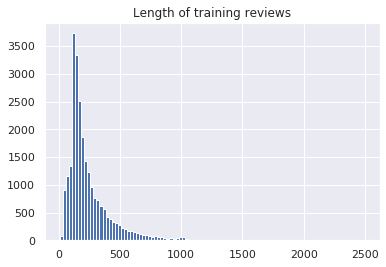

In [6]:
l = []
for i in range(len(x_train)):
    l.append(len(x_train[i]))
plt.figure()
plt.title('Length of training reviews')
plt.hist(l,100);

Since the movie reviews must be the same length, we will use the `pad_sequences` function to standardize the lengths

Pad sequences (samples x time)
x_train: (25000, 256)
x_test: (25000, 256)
First review in the training set:
 [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   1

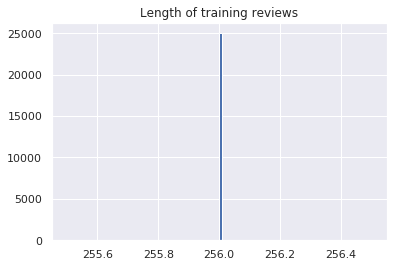

In [7]:
maxlen = 256

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen,
                                 padding='post', truncating='post')
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, 
                                padding='post', truncating='post')
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

print("First review in the training set:\n", x_train[0], 'length:', len(x_train[0]))

l = []
for i in range(len(x_train)):
    l.append(len(x_train[i]))
plt.figure()
plt.title('Length of training reviews')
plt.hist(l,100);

# 1D CNN Model - Convolutional Layers

## Initialization

Let's create a 1D CNN model that has one convolutional layers with *relu* as the activation function, followed by a *Dense* layer.  The first layer in the network is an *Embedding* layer that converts integer indices to dense vectors of length `embedding_dims`.  Dropout is applied after embedding and dense layers, and max pooling after the convolutional layers. The output layer contains a single neuron and *sigmoid* non-linearity to match the binary groundtruth (`y_train`). 

Finally, we `compile()` the model, using *binary crossentropy* as the loss function and [*RMSprop*](https://keras.io/optimizers/#rmsprop) as the optimizer.

In [8]:
# model parameter:
nb_words = 10000
maxlen = 256

embedding_dims = 50
cnn_filters = 100
cnn_kernel_size = 5
dense_hidden_dims = 200

print('Build model...')
model = Sequential()

model.add(Embedding(nb_words, embedding_dims, input_length=maxlen)) 
model.add(Dropout(0.2))

#conv 1

model.add(Conv1D(cnn_filters, cnn_kernel_size, padding='valid', activation='sigmoid'))
model.add(GlobalAveragePooling1D())

model.add(Dense(dense_hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Build model...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 50)           500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 252, 100)          25100     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
______________________

The layers are stacked sequentially to build the classifier:

- The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).
- Next, a GlobalMaxPooling1D layer returns a fixed-length output vector for each example by searching max value over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
- This fixed-length output vector is piped through a fully-connected (Dense) layer.
- The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.


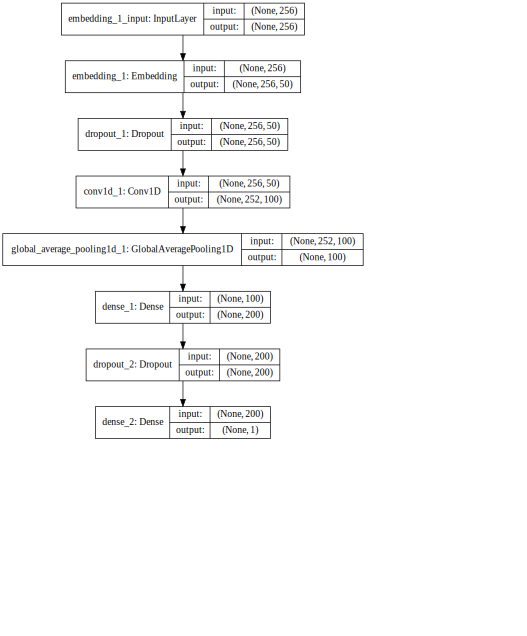

In [9]:
SVG(model_to_dot(model, show_shapes=True,dpi=50).create(prog='dot', format='svg'))

## Learning

Now we are ready to train our model.  An *epoch* means one pass through the whole training data. Note also that we are using a fraction of the training data as our validation set.

In [0]:
pat = 5 #ini adalah jumlah epoch tanpa peningkatan setelah pelatihan akan berhenti
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#tentukan callback model pos pemeriksaan -> ini akan terus menyimpan model sebagai file fisik
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [11]:
n_folds=10
epochs=5
batch_size=128

#simpan histori model dalam daftar setelah pemasangan sehingga kita dapat merencanakannya nanti
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    # train = tokenizeX(reviews_train_clean)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1



Train on 20250 samples, validate on 2250 samples
Epoch 1/5





20250/20250 [==============================] - 3s 159us/step - loss: 0.6491 - acc: 0.6088 - val_loss: 0.4987 - val_acc: 0.8080

Epoch 00001: val_loss improved from inf to 0.49874, saving model to fas_mnist_1.h5
Epoch 2/5
20250/20250 [==============================] - 1s 43us/step - loss: 0.3890 - acc: 0.8352 - val_loss: 0.5181 - val_acc: 0.7453

Epoch 00002: val_loss did not improve from 0.49874
Epoch 3/5
20250/20250 [==============================] - 1s 45us/step - loss: 0.2976 - acc: 0.8766 - val_loss: 0.3013 - val_acc: 0.8813

Epoch 00003: val_loss improved from 0.49874 to 0.30128, saving model to fas_mnist_1.h5
Epoch 4/5
20250/20250 [==============================] - 1s 44us/step - loss: 0.2558 - acc: 0.8970 - val_loss: 0.2992 - val_acc: 0.8782

Epoch 00004: val_loss improved from 0.30128 to 0.29922, saving model to fas_mnist_1.h5
Epoch 5/5
20250/20250 [==============================] - 1s 43us/

Let's plot the data to see how the training progressed. A big gap between training and validation accuracies would suggest overfitting.

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about eight epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

## Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [12]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 83.29%


We can also use the learned model to predict sentiments for new reviews:

In [13]:
myreviewtext = 'this movie was the worst i have ever seen and the actors were horrible'
#myreviewtext = 'this movie is great and i madly love the plot from beginning to end'

myreview = np.zeros((1,maxlen), dtype=int)
myreview[0, 0] = 1

for i, w in enumerate(myreviewtext.split()):
    if w in word_index and word_index[w]+3<nb_words:
        myreview[0, i+1] = word_index[w]+3
    else:
        print('word not in vocabulary:', w)
        myreview[0, i+1] = 2

print(myreview, "shape:", myreview.shape)

p = model.predict(myreview, batch_size=1)
print('Predicted sentiment: {:.10f}'.format(p[0,0]))
print('Note: Values close to "0" mean negative, close to "1" positive')

[[  1  14  20  16   4 249  13  28 126 110   5   4 156  71 527   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 

# 1D CNN Model  - 2 convolutional layers

## Initialization

Let's create a 1D CNN model that has two convolutional layers with *relu* as the activation function, followed by a *Dense* layer.  The first layer in the network is an *Embedding* layer that converts integer indices to dense vectors of length `embedding_dims`.  Dropout is applied after embedding and dense layers, and max pooling after the convolutional layers. The output layer contains a single neuron and *sigmoid* non-linearity to match the binary groundtruth (`y_train`). 

Finally, we `compile()` the model, using *binary crossentropy* as the loss function and [*RMSprop*](https://keras.io/optimizers/#rmsprop) as the optimizer.

In [14]:
# model parameters:
nb_words = 10000
maxlen = 256

embedding_dims = 50
cnn_filters = 100
cnn_kernel_size = 5
dense_hidden_dims = 200

print('Build model...')
model = Sequential()

model.add(Embedding(nb_words, embedding_dims, input_length=maxlen))
model.add(Dropout(0.2))

#conv 1

model.add(Conv1D(cnn_filters, cnn_kernel_size, padding='valid', activation='sigmoid'))
model.add(AveragePooling1D(5)) 

#conv 2

model.add(Conv1D(cnn_filters, cnn_kernel_size, padding='valid', activation='sigmoid'))
model.add(GlobalAveragePooling1D())

model.add(Dense(dense_hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(dense_hidden_dims, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Build model...

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 50)           500000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 252, 100)          25100     
_________________________________________________________________
average_pooling1d_1 (Average (None, 50, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 100)           50100     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20

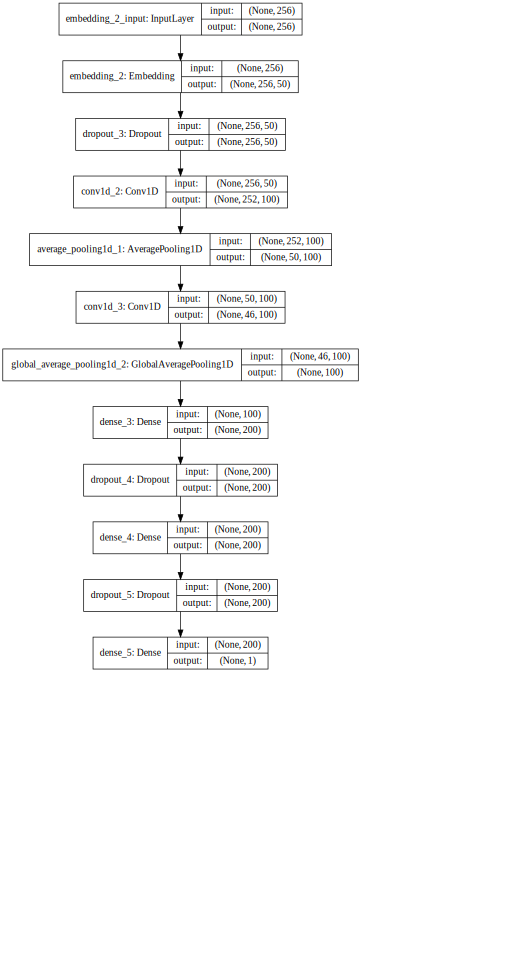

In [15]:
SVG(model_to_dot(model, show_shapes=True, dpi=50).create(prog='dot', format='svg'))

### Learning

In [0]:
pat = 5 #ini adalah jumlah epoch tanpa peningkatan setelah pelatihan akan berhenti
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#tentukan callback model pos pemeriksaan -> ini akan terus menyimpan model sebagai file fisik
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [17]:
n_folds=10
epochs=5
batch_size=128

#simpan histori model dalam daftar setelah pemasangan sehingga kita dapat merencanakannya nanti
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    # train = tokenizeX(reviews_train_clean)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Train on 20250 samples, validate on 2250 samples
Epoch 1/5
20250/20250 [==============================] - 2s 80us/step - loss: 0.7129 - acc: 0.4955 - val_loss: 0.6927 - val_acc: 0.4911

Epoch 00001: val_loss improved from inf to 0.69268, saving model to fas_mnist_1.h5
Epoch 2/5
20250/20250 [==============================] - 1s 56us/step - loss: 0.6020 - acc: 0.6520 - val_loss: 0.4257 - val_acc: 0.8293

Epoch 00002: val_loss improved from 0.69268 to 0.42569, saving model to fas_mnist_1.h5
Epoch 3/5
20250/20250 [==============================] - 1s 55us/step - loss: 0.4155 - acc: 0.8117 - val_loss: 0.3843 - val_acc: 0.8284

Epoch 00003: val_loss improved from 0.42569 to 0.38435, saving model to fas_mnist_1.h5
Epoch 4/5
20250/20250 [==============================] - 1s 56us/step - loss: 0.3454 - acc: 0.8527 - val_loss: 0.4973 - val_acc: 0.7836

Epoch 00004: val_loss did not improve from 0.38435
Epoch 5/5
20250/20250 [==============================] - 1s 55us/step - lo

### Inference

In [18]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 82.24%
